# Exploring the Spatial Determinants of Violent Crime: The Role of Built Environment and Socio-Economic Factors in London

## Preparation

- [Github link](https://github.com/chenyiting1003/casa0006-assessment) *[Optional]*

- Number of words: 1479

- Runtime: 35 mins (*Memory 10 GB, CPU Intel i7-10700 CPU @2.90GHz*)

- Coding environment: SDS Docker (or anything else)

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/) (or other license that you like).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **osmnx**: For downloading POIs data.
    - **libpysal.weights**: For spatial weights matrix to explore spatial spillover effect.
    - **IPython.display**:Display Markdown content

## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

Violent crime represents a critical challenge to social stability and urban development(Farrall et al., 2000; Lorenc et al., 2013). Understanding the spatial dynamics of violent crime has therefore become a key concern in urban studies. 

Existing research has explored its relationship with a variety of influencing factors, including income inequality, employment levels, ethnic diversity, and age structure(Hipp, 2007; Kassem et al., 2019; Kang, 2016; Semukhina et al., 2024; Cai et al., 2025). A growing body of literature also highlights the role of land use and built environment features, which cause 'hotspots', though findings suggest their relationship with violent crime is often complex and non-linear (P. Brantingham & Brantingham, 1995; Braga & Weisburd, 2010; Sadeek et al., 2019; He and Li, 2022). Studies have further proposed concepts such as spatial spillover effects, where crime in one area influences nearby areas (Kane & Hipp, 2017; Chen et al., 2024), and spatial interaction effects, where multifunctional urban spaces may amplify crime risks due to overlapping land use patterns (Kim & Hipp, 2021; Cui & MacDonald, 2021).

This study focuses on London, integrating violent crime records, socio-economic indicators, and detailed point-of-interest (POI) data. Aims to investigate how the built environment is associated with violent crime.

In [6]:
# Spatial Libraries
import osmnx as ox                      # For downloading POIs
import geopandas as gpd                # For handling geospatial data
from shapely.geometry import Polygon, MultiPolygon  # For geometric operations
from libpysal.weights import DistanceBand, KNN        # For defining spatial weights
from libpysal.weights import lag_spatial              # For computing spatial lags

# Data Processing and Visualization
import pandas as pd                    # Data manipulation
import numpy as np                     # Numerical operations
import matplotlib.pyplot as plt        # Plotting library
import seaborn as sns                  # Enhanced statistical plotting
from IPython.display import display, Markdown  # For displaying formatted output in notebooks

# Statistical Analysis
import statsmodels.api as sm                          # Statistical models and QQ plots
from statsmodels.tools.tools import add_constant      
from statsmodels.stats.outliers_influence import variance_inflation_factor  # VIF calculation
import scipy.stats as stats                           # Additional statistical tools

# Machine Learning
import sklearn
from sklearn.cluster import KMeans                    # Clustering algorithm
from sklearn.decomposition import PCA                 # Dimensionality reduction
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve  # Model selection
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score         # Model evaluation

from sklearn.ensemble import RandomForestRegressor    # Random Forest

import xgboost
from xgboost import XGBRegressor                      # XGBoost 

import rfpimp                                         # Feature Importance


## Research questions

[[ go back to the top ]](#Table-of-contents)

1.What is the relationship between built environment types and violent crime in urban areas?

2.How do built environment types and their interactions influence violent crime rates?

3.How accurately can machine learning models predict violent crime based on spatial and socio-economic features?


## Data

[[ go back to the top ]](#Table-of-contents)

This study uses POI data to represent built environment features due to their clear categorization, spatial accuracy, and large coverage. To improve analytical robustness, a set of socio-economic indicators were included based on prior research.

|Category  |  Name of Variable  | Type         | Description                                                 |Source	|Years |
|----------|------------------|--------------|-------------------------------------------------------------|--------|--------|
| Violent crime Rate  | violent_crime_per_100| Numeric      | The violent crime rate represents the number of violent incidents per 100 residents within each LSOA, adjusted for population size to enable  spatial comparison. |Metropolitan Police|2024|
|Income Deprivation Index| income_deprivation  | Numeric      | A composite measure indicating the proportion of people experiencing income-related disadvantage, including those on low income or receiving welfare benefits.|UK Census|2021|
|Education Index| education_index     | Numeric      | The education index assigning numeric scores (0–5) to qualification levels and calculating a weighted average based on the population in each LSOA. It reflects the overall level of educational attainment in each area.  |UK Census|2021|
|Ethnic Diversity Index | ethnic_diversity_index | Numeric      | To measure ethnic diversity at the LSOA level in London, I adopted the Herfindahl-Hirschman Index (HHI), based on previous research (Lieberson, 1969; Domínguez, 2021). The diversity index ranges from 0 (complete homogeneity) to values approaching 1 (maximum heterogeneity), with higher values indicating greater ethnic diversity within an area.$$HHI = \sum_{i=1}^{n} p_i^2,\quad \text{Diversity Index} = 1 - HHI$$|UK Census|2021|
| Employed Index| employed_index      | Numeric      | The proportion of employed individuals relative to the working-age population (16–65) in each LSOA, which reflects local employment levels.|UK Census|2021|
| Population Data | population_2021     | Numeric      | Total residents population in each lsoa           |UK Census|2021|
|POI Density| commercial_density; police_related_density; urban_utilities_density; residential_density; financial_density; education_density; religion_density; entertainment_density; leisure_density; community_density; healthcare_density; transport_density; parking_related_density; other_density               | Numeric  |Represents the spatial density of each POI type within an LSOA, calculated by dividing the POI count by the area size to account for variation in LSOA land area.| OSMnx  | 2024 |
| Geographic Data | lsoa                    | Geometry | LSOA area code identifier and polygon                     | ONS  | 2024 |

*Table 1. Describing the data*


In [12]:
# Read the data files
lsoa = gpd.read_file(
    "https://raw.githubusercontent.com/chenyiting1003/casa0006-assessment/5bbfcfdc20161ac907641683d30c9ac79bc3e20f/data/lsoa/LSOA_2011_London_gen_MHW.shp")

population_df = pd.read_csv(
    "https://raw.githubusercontent.com/chenyiting1003/casa0006-assessment/5bbfcfdc20161ac907641683d30c9ac79bc3e20f/data/population2021.csv")

deprivation_df = pd.read_csv(
    "https://raw.githubusercontent.com/chenyiting1003/casa0006-assessment/5bbfcfdc20161ac907641683d30c9ac79bc3e20f/data/income_deprivation_data.csv")

ethnic_df = pd.read_csv(
    "https://raw.githubusercontent.com/chenyiting1003/casa0006-assessment/5bbfcfdc20161ac907641683d30c9ac79bc3e20f/data/ethnic_index_21.csv")

occupation_df = pd.read_csv(
    "https://raw.githubusercontent.com/chenyiting1003/casa0006-assessment/5bbfcfdc20161ac907641683d30c9ac79bc3e20f/data/occupation_population.csv")

In [13]:
# Clean crime data
crime_original_df = pd.read_csv(
    "https://raw.githubusercontent.com/chenyiting1003/casa0006-assessment/5bbfcfdc20161ac907641683d30c9ac79bc3e20f/data/MPS%20LSOA%20Level%20Crime%20(most%20recent%2024%20months).csv"
)

# Divide the Major Category into three categories: violence, economic, and public order crimes
crime_categories = {
    'VIOLENCE AGAINST THE PERSON': 'violent_crime',
    'ROBBERY': 'violent_crime',
    'POSSESSION OF WEAPONS': 'violent_crime',
    'BURGLARY': 'property_crime',
    'THEFT': 'property_crime',
    'VEHICLE OFFENCES': 'property_crime',
    'DRUG OFFENCES': 'order_crime',
    'PUBLIC ORDER OFFENCES': 'order_crime',
    'MISCELLANEOUS CRIMES AGAINST SOCIETY': 'order_crime'
}

crime_original_df['crime_group'] = crime_original_df['Major Category'].map(crime_categories)

# Just use crime data in 2024
crime_month_cols = [col for col in crime_original_df.columns if col.startswith("2024")]

# Sum the data by crime_group and LSOA, since the other variables are in years.
crime_grouped = crime_original_df.groupby(['LSOA Code', 'crime_group'])[crime_month_cols].sum()

# Expand crime_group into columns
crime_summary = crime_grouped.unstack(fill_value=0)
crime_summary.columns = ['_'.join(col).strip() for col in crime_summary.columns.values]

# Change to Normal Form
crime_summary = crime_summary.reset_index()
crime_summary.columns = crime_summary.columns.astype(str)

# Redefine the column name filter to ensure matching
violent_cols = [col for col in crime_summary.columns if '_violent_crime' in col]
property_cols = [col for col in crime_summary.columns if '_property_crime' in col]
order_cols = [col for col in crime_summary.columns if '_order_crime' in col]

# Change related columns to numeric values to prevent NA
for col in violent_cols + property_cols + order_cols:
    crime_summary[col] = pd.to_numeric(crime_summary[col], errors='coerce')

# Sum to total crime column
crime_summary['violent_crime_total'] = crime_summary[violent_cols].sum(axis=1, skipna=True)
crime_summary['property_crime_total'] = crime_summary[property_cols].sum(axis=1, skipna=True)
crime_summary['order_crime_total'] = crime_summary[order_cols].sum(axis=1, skipna=True)
crime_summary['all_crime_total'] = crime_summary[[
    'violent_crime_total','property_crime_total','order_crime_total']].sum(axis=1, skipna=True)

crime_df = crime_summary.rename(columns={
    "LSOA Code": "lsoacode"
})


In [14]:
# Clean education data
edu_original_df = pd.read_csv(
    "https://raw.githubusercontent.com/chenyiting1003/casa0006-assessment/5bbfcfdc20161ac907641683d30c9ac79bc3e20f/data/edu2021.csv")

# Filter out "Does not apply" (-8 categories)
edu_df_filtered = edu_original_df[edu_original_df[
"Highest level of qualification (8 categories)"] != "Does not apply"].copy()

# Change score
edu_df_filtered["score"] = edu_df_filtered[
"Highest level of qualification (8 categories) Code"].map({
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 3
})

# Calculate the score of each row × the number of people
edu_df_filtered["weighted_score"] = edu_df_filtered["score"] * edu_df_filtered["Observation"]

# Weighted score / Total number of people
education_index = (
    edu_df_filtered.groupby("Lower layer Super Output Areas Code")  # or "Lower layer"
    .agg(
        total_score=("weighted_score", "sum"),
        total_population=("Observation", "sum")
    )
)

education_index["education_index"] = education_index["total_score"] / education_index["total_population"]

# Finally, only retain the education_index column
education_index = education_index[["education_index"]].reset_index()

edu_df = education_index.rename(columns={
    "Lower layer Super Output Areas Code": "lsoacode"
})


In [15]:
# Clean poi data
# POIs: amenity, shop, leisure, building

# This may take some time, if it takes too long, please use my processed data
# poi_df = pd.read_csv("https://raw.githubusercontent.com/chenyiting1003/casa0006-assessment/5bbfcfdc20161ac907641683d30c9ac79bc3e20f/data/lsoa_poi_counts.csv")

# London Border
city = ox.geocode_to_gdf("Greater London, UK")
polygon = city.loc[0, 'geometry']

# amenity
tags = {'amenity': True,}
pois_amenity = ox.features.features_from_polygon(polygon, tags)

In [16]:
# shop
tags = {'shop': True,}
pois_shop = ox.features.features_from_polygon(polygon, tags)

In [17]:
# leisure
tags = {'leisure': True,}
pois_leisure = ox.features.features_from_polygon(polygon, tags)

# building
tags = {'building': ['residential', 'apartments', 'retail', 'school', 'hospital']}
pois_building = ox.features.features_from_polygon(polygon, tags)

# merge
pois = pd.concat([pois_amenity, pois_shop, pois_leisure, pois_building], ignore_index=True)

# Change the coordinate system to EPSG:27700 to match LSOA
pois = pois.to_crs(epsg=27700)

In [18]:
# Filter useful POI tags
useful_columns = ['geometry', 'amenity', 'shop', 
                  'leisure', 'tourism', 'healthcare', 
                  'office', 'man_made', 'building', 
                  'name']

pois = pois[useful_columns].copy()

pois[useful_columns].notnull().sum().sort_values(ascending=False)

def categorize_poi(row):
    # Priority: amenity > shop > leisure > tourism > healthcare > building
    if pd.notnull(row.get('amenity')):
        value = row['amenity']
        if value in ['pub', 'bar', 'nightclub']:
            return 'alcohol_related'
        elif value in ['fast_food', 'restaurant', 'cafe']:
            return 'food_related'
        elif value in ['police']:
            return 'police_related'
        elif value in ['school', 'college', 'university',
                       'prep_school', 'language_school']:
            return 'education'
        elif value in ['hospital', 'clinic', 'doctors', 
                       'pharmacy', 'dentist']:
            return 'healthcare'
        elif value in ['bank', 'atm', 'bureau_de_change']:
            return 'financial'
        elif value in ['bus_station', 'taxi', 'train_station']:
            return 'transport'
        elif value in ['fire_station', 'courthouse', 'public_building', 
                       'community_centre', 'library', 'post_office', 
                       'social_facility', 'childcare', 'kindergarten']:
            return 'community'
        elif value in ['place_of_worship', 'church', 'mosque']:
            return 'religion'
        elif value in ['cinema', 'arts_centre', 'events_venue', 
                       'studio', 'theatre','casino']:
            return 'entertainment'
        elif value in ['waste_basket', 'recycling', 'waste_disposal', 
                       'grit_bin', 'drinking_water', 'toilets', 
                       'fountain', 'bench', 'telephone', 'shelter']:
            return 'urban_utilities'
        elif value in ['parking', 'parking_space', 'motorcycle_parking', 
                       'bicycle_parking', 'parking_entrance', 'car_sharing', 
                       'fuel', 'charging_station', 'bicycle_rental']:
            return 'parking_related'
        elif value in ['marketplace', 'vending_machine', 'parcel_locker', 
                       'supermarket', 'convenience', 'clothes', 
                       'bakery', 'department_store']:
            return 'retail'

    if pd.notnull(row.get('shop')):
        value = row['shop']
        if value in ['marketplace', 'vending_machine', 'parcel_locker', 
                     'supermarket', 'convenience', 'clothes', 
                     'bakery', 'department_store']:
            return 'retail'

    if pd.notnull(row.get('leisure')):
        value = row['leisure']
        if value in ['park', 'cinema', 'sports_centre', 
                     'stadium', 'playground']:
            return 'leisure'

    if pd.notnull(row.get('tourism')):
        value = row['tourism']
        if value in ['museum', 'artwork', 'attraction']:
            return 'entertainment'

    if pd.notnull(row.get('healthcare','nursing_home')):
        return 'healthcare'

    if pd.notnull(row.get('building')):
        value = row['building']
        if value in ['residential', 'apartments', 'flats']:
            return 'residential'

    return 'other'

pois['category'] = pois.apply(categorize_poi, axis=1)

pois[pois['category'] == 'other']['amenity'].value_counts().head(30)


amenity
post_box                  7900
car_wash                   244
veterinary                 239
clock                      203
ice_cream                  173
grave_yard                 152
ticket_validator           131
car_rental                 129
money_transfer             121
post_depot                 103
public_bookcase             97
bicycle_repair_station      87
internet_cafe               75
loading_dock                72
bus_garage                  61
trolley_bay                 59
photo_booth                 56
ferry_terminal              49
waste_transfer_station      48
hunting_stand               47
townhall                    46
social_centre               46
food_court                  43
nursing_home                38
dojo                        32
social_club                 32
water_point                 30
escooter_rental             28
music_school                28
gambling                    28
Name: count, dtype: int64

In [19]:
pois['geometry'] = pois.geometry.centroid

pois.geom_type.value_counts()

joined = gpd.sjoin(pois, lsoa, how="inner", predicate="within")

poi_counts = joined.groupby(['LSOA11CD', 'category']).size().unstack(fill_value=0).reset_index()

poi_df = lsoa.merge(poi_counts, on="LSOA11CD", how="left").fillna(0)

C:\Users\17944\AppData\Local\Temp\ipykernel_15880\1935921712.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...

  joined = gpd.sjoin(pois, lsoa, how="inner", predicate="within")


## Methodology

[[ go back to the top ]](#Table-of-contents)

This study explore the relationship between violent crime rates and a range of socio-economic, built environment, and spatial interaction variables in London’s LSOAs.

![Methodology Flowchart](https://github.com/chenyiting1003/casa0006-assessment/raw/a72ee8de12c95fd8dbb5ac7d98eca0f4766cb95f/methodology_crime_poi.png)

*Figure 1. Methodological workflow. Source: Own elaboration.*


### Explanation

Raw datasets from multiple sources, were merged using LSOA identifier. The merged dataset was first cleaned by removing extreme outliers. Then variables were standardized using the IDR method, which is robust to skewed distributions and outliers. 

Data distribution was evaluated using Q-Q plots and maps, which can intuitively show the result.
Spearman correlation are well-suited for capturing non-linear relationships and do not require the assumption of normal data distribution.To check multicollinearity, Variance Inflation Factors (VIF<5) were calculated. Additionally, a K-Means clustering analysis was performed on the IDR-normalized dataset to explore latent structures among features. Cluster interpretation helped build spatial interaction variables.

Considering the non-linearity and complexity of urban crime data, ensemble Random Forest and XGBoost.Data was split into training : testing(75%:25%) . Hyperparameter tuning for the Random Forest model was conducted via GridSearchCV to optimize depth and split thresholds.
A baseline model using all selected variables was first trained. Then, three spatial interaction variables were designed:

Calculate the average violent crime rate by identifying each LSOA’s five geographically nearest neighbors (violent_crime_spatial_avg_per_100) – This spatial lag variable captures spatial spillover effects, reflecting how crime patterns in adjacent areas may influence a given location. This concept is supported by spatial criminology research (e.g., Baller et al., 2001; Andresen, 2016).

Calculate the interaction between commercial & residential and commercial & financial POI densities (combo_comm_res_density; combo_comm_fin_density) – These spatial interaction variables were derived by combining the most important POI features identified in the baseline model with patterns observed in k-means clustering. They capture spatial overlap effects, where different types of facilities, when co-located, may jointly increase the opportunity or risk of crime (Davies & Johnson, 2015).

These were added to train new models and compared with the baseline model.

### Limitation

Some socio-economic variables are from 2021,based on UK census, while POI data and crime statistics are based on 2024, potentially introducing temporal mismatch. However, the 2024 crime dataset was prioritized to align with the primary research objective—examining the relationship between the built environment and crime patterns.

POI variables reflect density rather than accounting for functional service areas or precise building footprints, which may lead to an underestimation of the influence of certain built-environment features. Additionally, unobserved variables like policing levels or community interventions are not included, which may affect the accuracy of crime prediction.

## Results and discussion

[[ go back to the top ]](#Table-of-contents)

In [25]:
print(lsoa.head())

    LSOA11CD                   LSOA11NM   MSOA11CD                  MSOA11NM  \
0  E01000001        City of London 001A  E02000001        City of London 001   
1  E01000002        City of London 001B  E02000001        City of London 001   
2  E01000003        City of London 001C  E02000001        City of London 001   
3  E01000005        City of London 001E  E02000001        City of London 001   
4  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   

     LAD11CD               LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  \
0  E09000001        City of London  E12000007  London      1465      1465   
1  E09000001        City of London  E12000007  London      1436      1436   
2  E09000001        City of London  E12000007  London      1346      1250   
3  E09000001        City of London  E12000007  London       985       985   
4  E09000002  Barking and Dagenham  E12000007  London      1703      1699   

   COMESTRES  POPDEN  HHOLDS  AVHHOLDSZ  \
0          0 

In [26]:
print(crime_df.head())

    lsoacode  202401_order_crime  202401_property_crime  202401_violent_crime  \
0  E01000006                   2                      7                     2   
1  E01000007                  14                     12                    18   
2  E01000008                   0                      7                     5   
3  E01000009                   7                     11                     8   
4  E01000011                   1                      1                     5   

   202402_order_crime  202402_property_crime  202402_violent_crime  \
0                   1                      1                     4   
1                   6                     17                    16   
2                   0                      6                     5   
3                   4                     13                     8   
4                   0                      3                     5   

   202403_order_crime  202403_property_crime  202403_violent_crime  ...  \
0                

In [27]:
print(poi_df.head())

    LSOA11CD                   LSOA11NM   MSOA11CD                  MSOA11NM  \
0  E01000001        City of London 001A  E02000001        City of London 001   
1  E01000002        City of London 001B  E02000001        City of London 001   
2  E01000003        City of London 001C  E02000001        City of London 001   
3  E01000005        City of London 001E  E02000001        City of London 001   
4  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   

     LAD11CD               LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  \
0  E09000001        City of London  E12000007  London      1465      1465   
1  E09000001        City of London  E12000007  London      1436      1436   
2  E09000001        City of London  E12000007  London      1346      1250   
3  E09000001        City of London  E12000007  London       985       985   
4  E09000002  Barking and Dagenham  E12000007  London      1703      1699   

   ...  healthcare  leisure  other  parking_related poli

In [28]:
print(population_df.head())

    lsoacode population_21
0  E01010930          1666
1  E01010931          1408
2  E01010932          1565
3  E01010933          1660
4  E01010934          1954


In [29]:
print(deprivation_df.head())

  LSOA code (2011) LSOA name (2011)  income_deprivation
0        E01031338        Adur 002A               0.054
1        E01031339        Adur 002B               0.052
2        E01031340        Adur 002C               0.027
3        E01031341        Adur 008A               0.237
4        E01031342        Adur 008B               0.083


In [30]:
print(edu_df.head())

    lsoacode  education_index
0  E01000001         4.579453
1  E01000002         4.604006
2  E01000003         4.077741
3  E01000005         3.068678
4  E01000006         2.884857


In [31]:
print(ethnic_df.head())

    lsoacode local authority name  ethnic_diversity_index
0  E01000001       City of London                0.635984
1  E01000002       City of London                0.661000
2  E01000003       City of London                0.690773
3  E01000005       City of London                0.854024
4  E01032739       City of London                0.773716


In [32]:
print(occupation_df.head())

    lsoacode  employ_population
0  E01000001                868
1  E01000002                875
2  E01000003               1002
3  E01000005                494
4  E01032739               1184


In [33]:
#Calculate the impact of crime neighborhoods - spatial lag

#Merge data to ensure consistent keys: LSOA11CD is the column name in the spatial data
lsoa = lsoa.merge(
    crime_df[["lsoacode", "violent_crime_total"]],
    left_on="LSOA11CD",
    right_on="lsoacode",
    how="left"
)

lsoa = lsoa.dropna(subset=["violent_crime_total"])

lsoa = lsoa.drop(columns=["LSOA11CD"])

# Calculates five neighboring regions
# This is because the lsoa boundary precision in the shp file 
# is problematic and cannot be recognized by the queen method, 
# so only use the five nearest neighbors.
w_knn = KNN.from_dataframe(lsoa, k=5)

lsoa = lsoa.reset_index(drop=True)

# Specifies the neighbor calculation method, based on the nearest distance
w_knn.transform = 'b'

# Calculate the average
lsoa["violent_crime_spatial_knn"] = lag_spatial(w_knn, lsoa["violent_crime_total"])
lsoa["violent_crime_spatial_avg"] = lsoa["violent_crime_spatial_knn"] / 5

In [34]:
#merge data
deprivation_df = deprivation_df.rename(columns={"LSOA code (2011)": "lsoacode"})

crime_socialeconomic_data = (
    crime_df
    .merge(population_df, on="lsoacode", how="left")
    .merge(deprivation_df[["lsoacode", "income_deprivation"]], on="lsoacode", how="left")
    .merge(edu_df, on="lsoacode", how="left")
    .merge(ethnic_df[["lsoacode", "ethnic_diversity_index"]], on="lsoacode", how="left")
    .merge(occupation_df, on="lsoacode", how="left")
)

crime_socialeconomic_data['population_21'] = pd.to_numeric(
    crime_socialeconomic_data['population_21'], errors='coerce'
)

crime_socialeconomic_data = crime_socialeconomic_data.dropna(subset=[
    'income_deprivation', 'population_21'])

crime_socialeconomic_data = (
    crime_socialeconomic_data
    .merge(lsoa[["lsoacode", "violent_crime_spatial_avg"]], 
           on="lsoacode", how="left")
)


In [35]:
# Standardized crime variables
# Variable names to be standardized and corresponding output column names 
# (per 100 residents)
per_100_vars = {
    'violent_crime_total': 'violent_crime_per_100',
    'property_crime_total':'property_crime_per_100',
    'order_crime_total': 'order_crime_per_100',
    'all_crime_total': 'all_crime_per_100',
    'violent_crime_spatial_avg': 'violent_crime_spatial_avg_per_100'    
}

for raw_col, new_col in per_100_vars.items():
    crime_socialeconomic_data[new_col] = (
        crime_socialeconomic_data[raw_col] / crime_socialeconomic_data['population_21']
    ) * 100

crime_socialeconomic_data['employed_index'] = (
    crime_socialeconomic_data['employ_population'] / crime_socialeconomic_data['population_21']
) 

# Columns to keep (Standardized Crime Rate + Socioeconomic Variables)
clean_columns = [
    'lsoacode',
    'violent_crime_per_100',
    'property_crime_per_100',
    'order_crime_per_100',
    'all_crime_per_100',
    'violent_crime_spatial_avg_per_100',
    'population_21',
    'income_deprivation',
    'education_index',
    'ethnic_diversity_index',
    'employed_index'
]

# Create a New DataFrame
crime_socialecon_clean = crime_socialeconomic_data[clean_columns]


In [36]:
# Standardize poi variables
# Calculate lsoa area/0.1km2, because some data are too small

# Calculate the area in square meters and convert to 0.1 square kilometers
lsoa["area_km2"] = lsoa.geometry.area / 1e6 *10

# Merge POI 
area_df = lsoa[["lsoacode", "area_km2"]].copy()
poi_df = poi_df.rename(columns={"LSOA11CD": "lsoacode"})
poi_df = poi_df.merge(area_df,
                      on="lsoacode", 
                      how="left")

poi_df["commercial"] = (
    poi_df["retail"] + 
    poi_df["food_related"] +
    poi_df["alcohol_related"]
)

# Calculate the density of each type of POI (per 0.1 square kilometers)
selected_poi_cols = [
    'commercial',
    'police_related', 'urban_utilities', 'residential',
    'financial',
    'education', 'religion', 
    'entertainment','leisure', 'community',
    'healthcare', 
    'transport', 
    'parking_related', 
    'other'
]

poi_density_df = poi_df[["lsoacode", "area_km2"]].copy()

poi_density_df = poi_density_df.dropna(subset=["area_km2"])

for col in selected_poi_cols:
    poi_density_df[f"{col}_density"] = poi_df[col] / poi_df["area_km2"]

# Merge all data
crime_socialeconomic_poi_data = crime_socialeconomic_data.merge(
    poi_density_df, on="lsoacode", how="left"
)

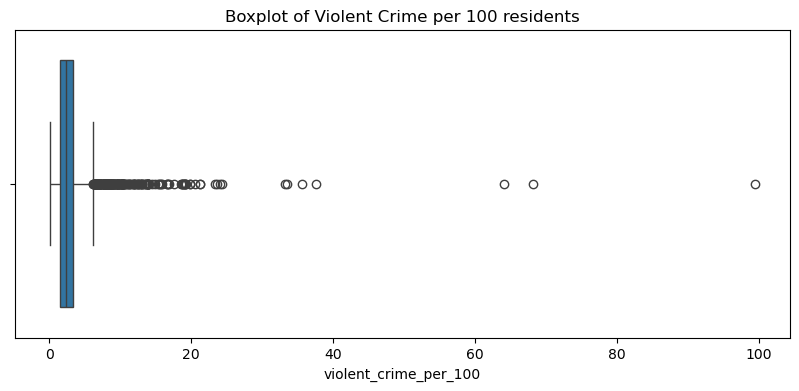

In [37]:
# Check crime outliers
plt.figure(figsize=(10,4))
sns.boxplot(x=crime_socialeconomic_poi_data['violent_crime_per_100'])
plt.title("Boxplot of Violent Crime per 100 residents")
plt.show()

In [38]:
# Remove the top 1% of violent_crime_per_100
threshold = crime_socialeconomic_poi_data['violent_crime_per_100'].quantile(0.99)

crime_socialeconomic_poi_filtered = crime_socialeconomic_poi_data[
    crime_socialeconomic_poi_data['violent_crime_per_100'] <= threshold
].copy()

print(f"kept data：{crime_socialeconomic_poi_filtered.shape[0]} ")
print(f"removed data：violent_crime_per_100 ≤ {threshold:.2f}")

kept data：4606 
removed data：violent_crime_per_100 ≤ 13.73


In [39]:
# Interaction effect variables
# commercial × finance density variables
crime_socialeconomic_poi_filtered["combo_comm_fin_density"] = (
    crime_socialeconomic_poi_filtered["commercial_density"] *
    crime_socialeconomic_poi_filtered["financial_density"]
)

# commercial × residential density variables
crime_socialeconomic_poi_filtered["combo_comm_res_density"] = (
    crime_socialeconomic_poi_filtered["commercial_density"] *
    crime_socialeconomic_poi_filtered["residential_density"]
)

In [40]:
# All research variables
corr_cols = [
    'violent_crime_per_100',
    'violent_crime_spatial_avg_per_100',
    'income_deprivation',
    'education_index',
    'ethnic_diversity_index',
    'employed_index',
    'commercial_density',
    'police_related_density', 
    'urban_utilities_density', 
    'residential_density',
    'financial_density',
    'education_density', 
    'religion_density', 
    'entertainment_density',
    'leisure_density', 
    'community_density',
    'healthcare_density', 
    'transport_density', 
    'parking_related_density', 
    'other_density'
]

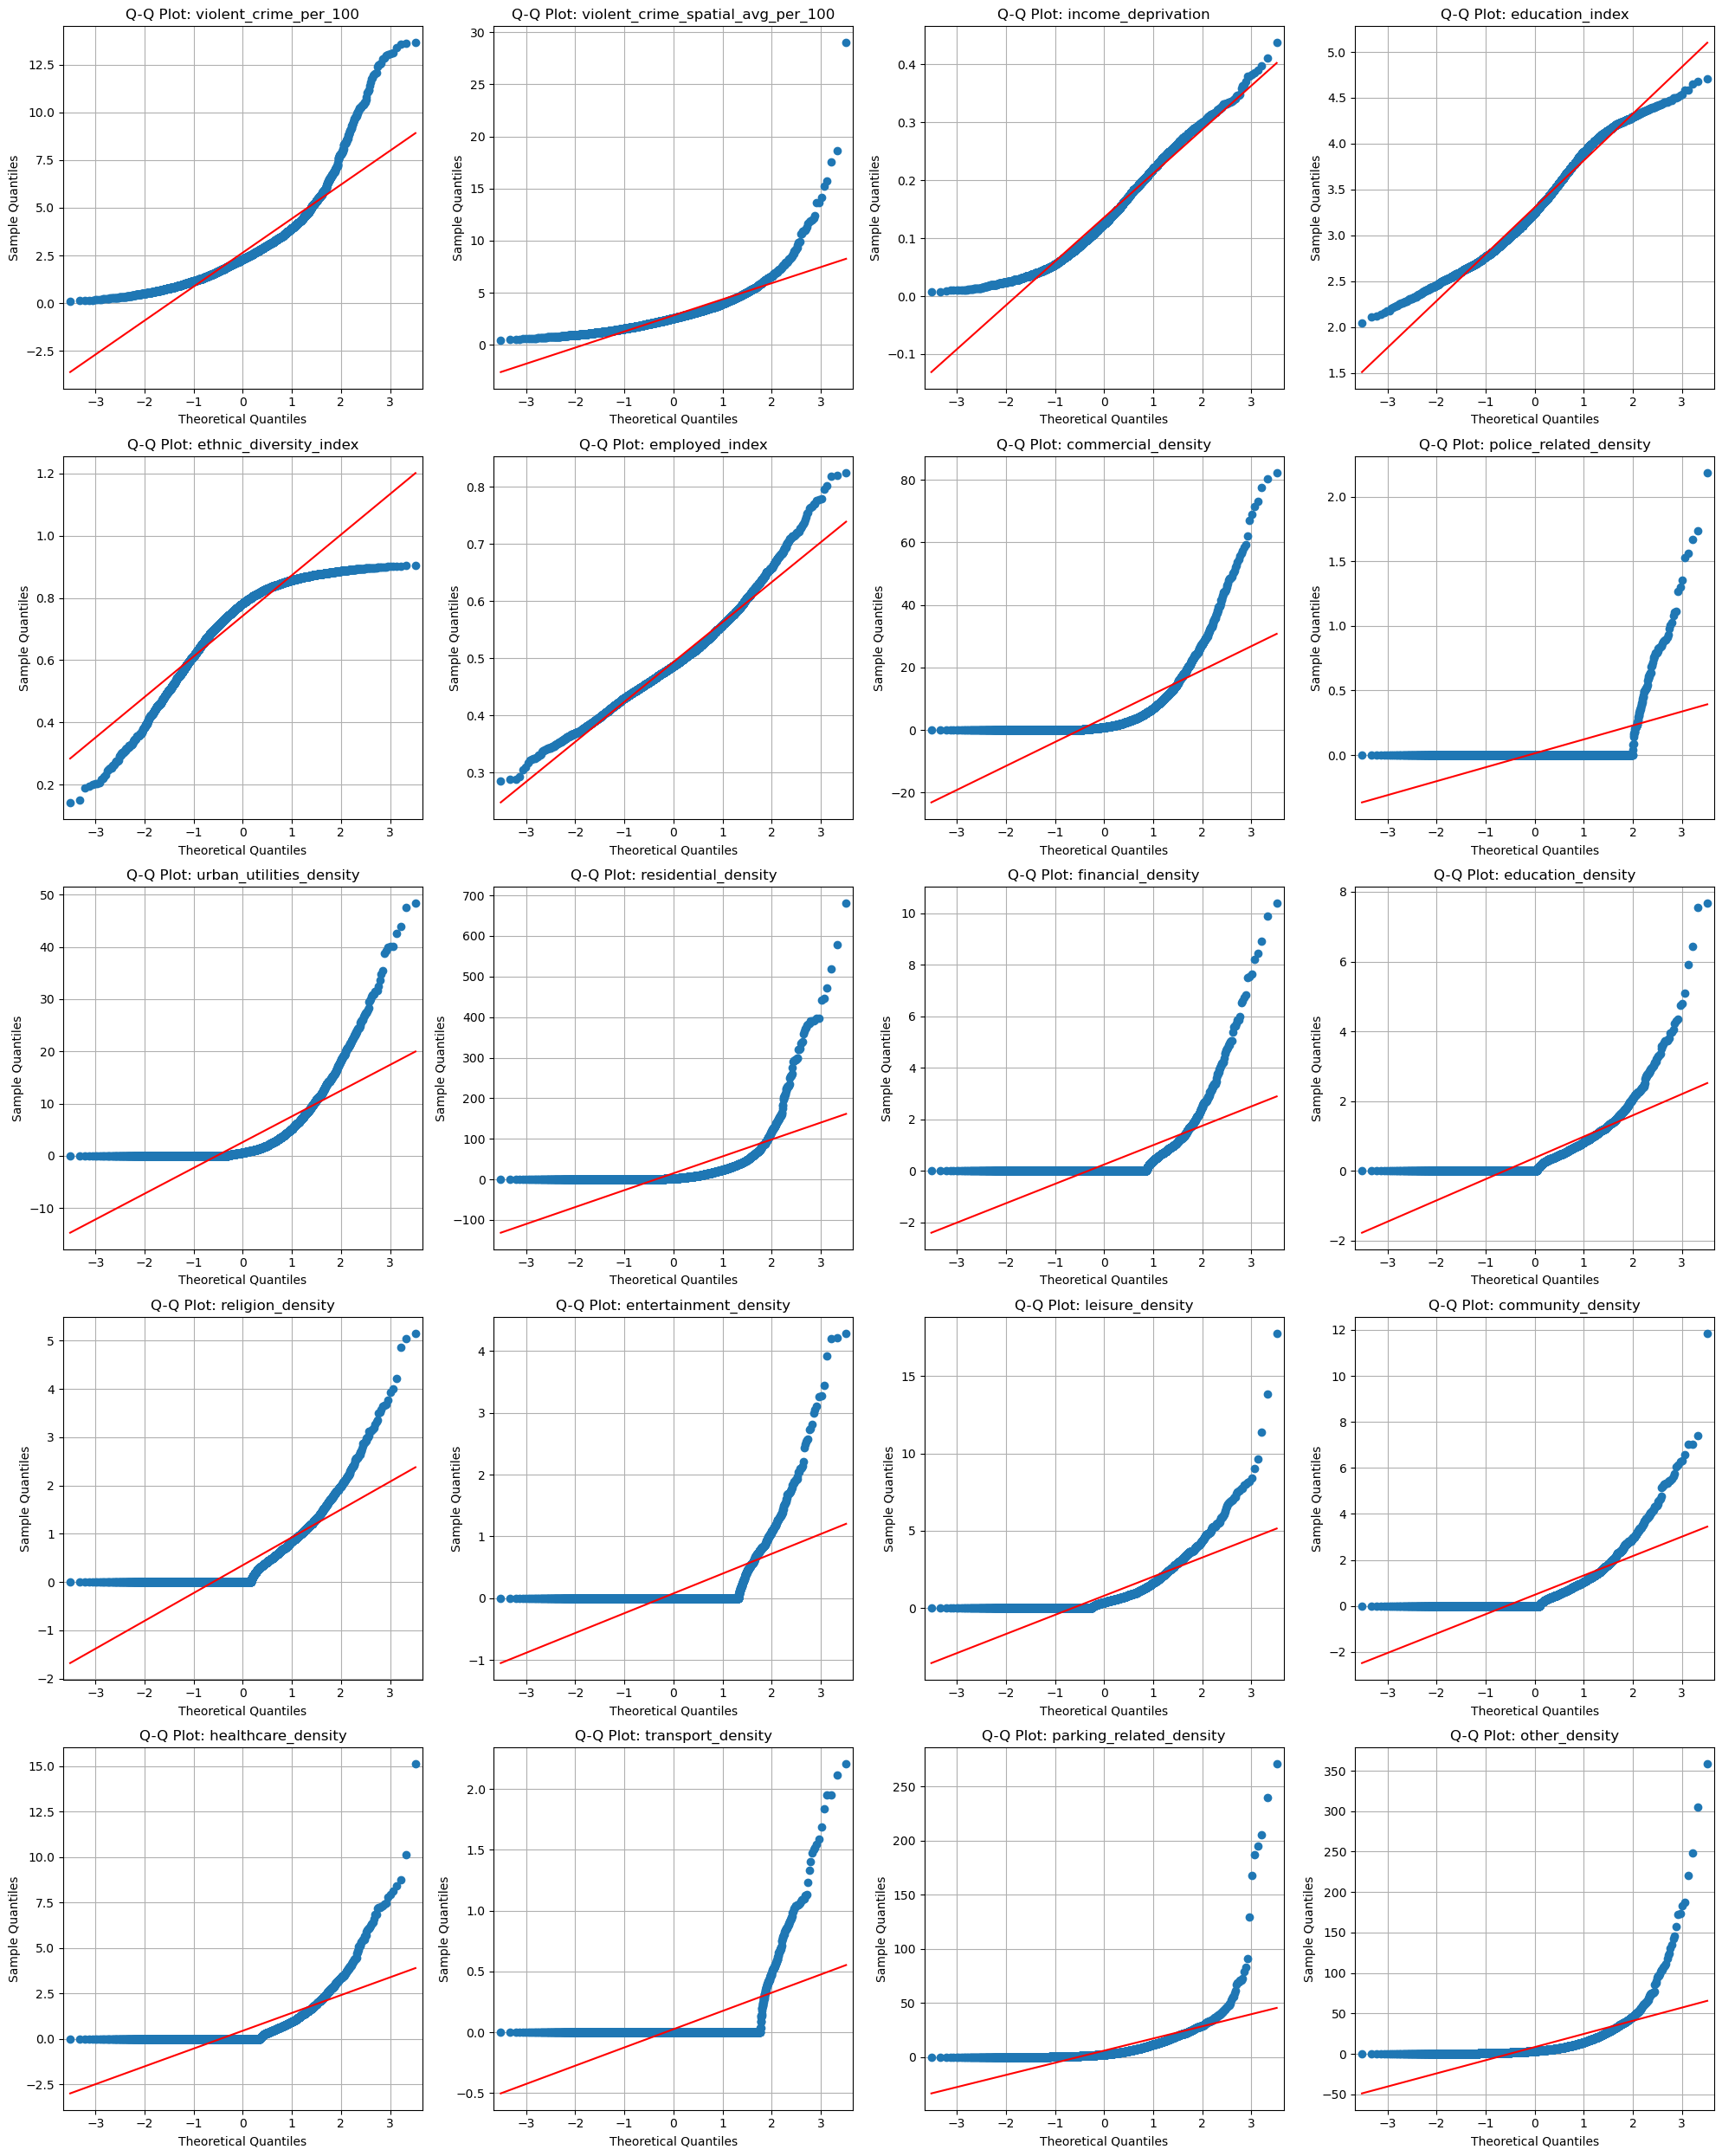

In [41]:
# Q-Q plot to check the distribution of variables
num_vars = len(corr_cols)
rows, cols = 5, 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 25))
axes = axes.flatten()

for i, col in enumerate(corr_cols):
    data = crime_socialeconomic_poi_filtered[col].dropna()
    sm.qqplot(data, line='s', dist=stats.norm, ax=axes[i])
    axes[i].set_title(f"Q-Q Plot: {col}")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

*Figure 2. Q-Q plots: Distribution of variables.*

### Distribution analysis

Q-Q plots showed that most variables do not follow a normal distribution, indicating complex, non-linear relationships between urban environments and crime.

Spearman correlation and non-parametric models such as Random Forest and XGBoost were selected, as they are well-suited for capturing non-linear relationships and do not require the assumption of normal data distribution.



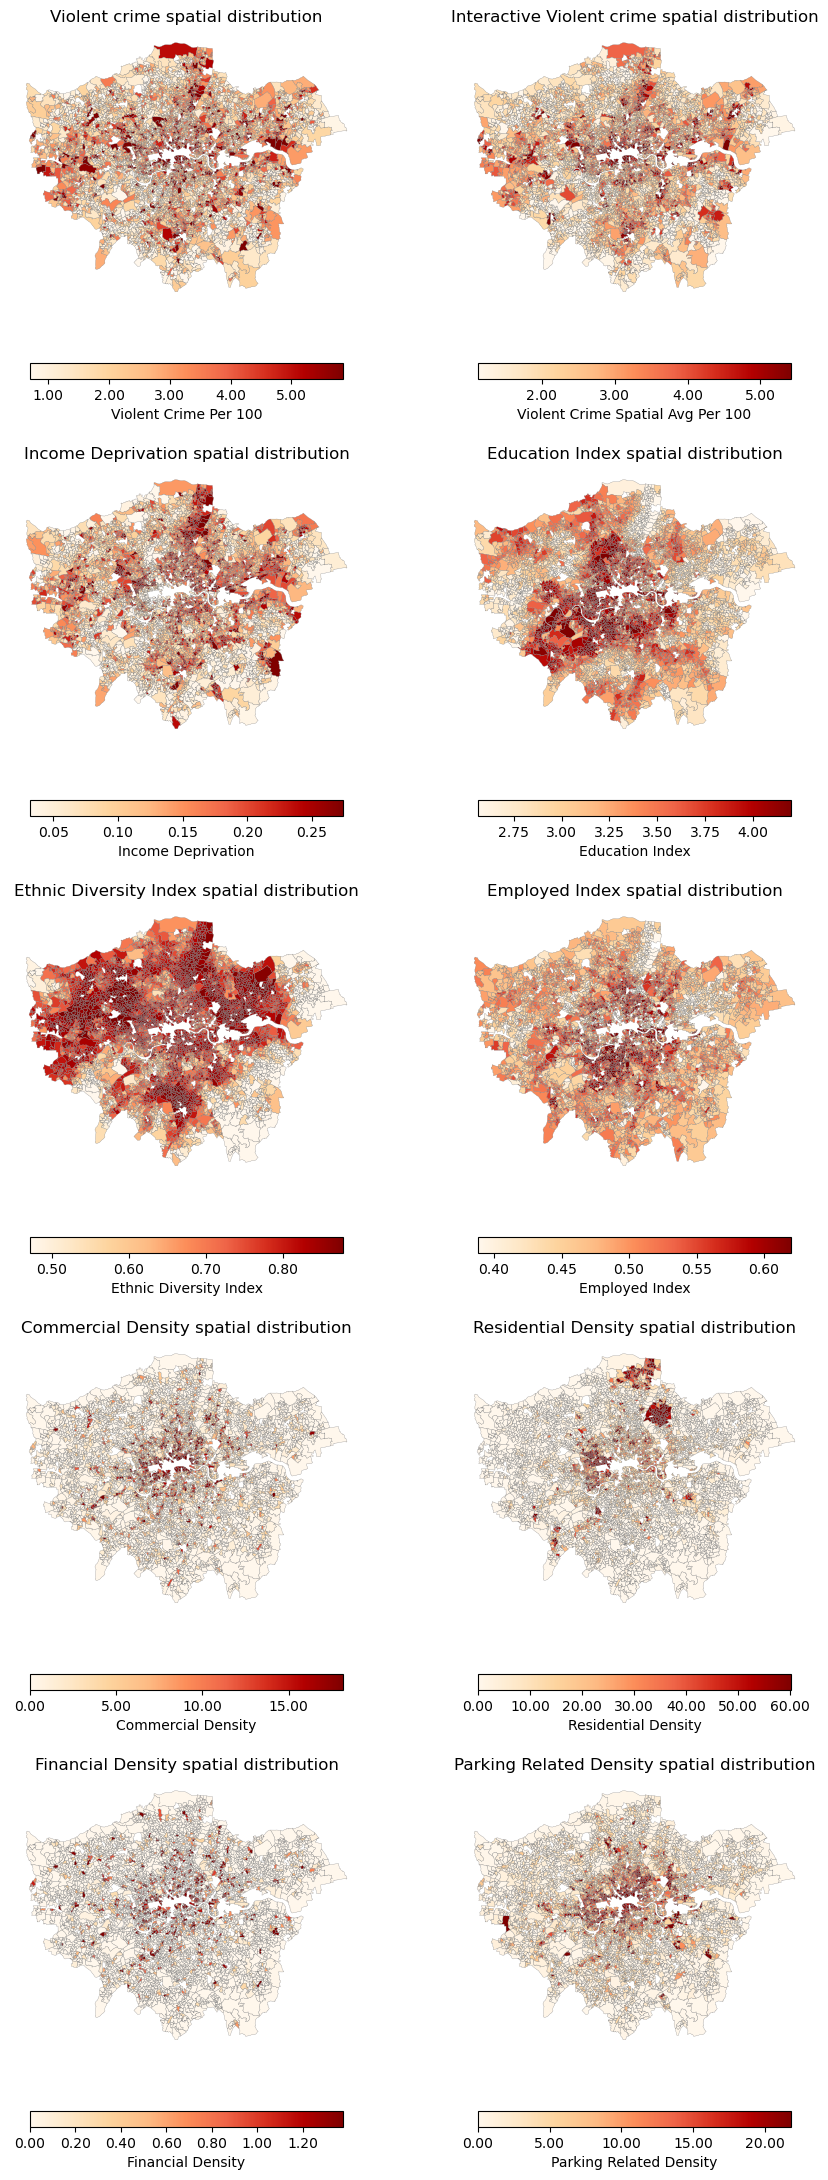

In [43]:
# Spatial mapping
cols_to_spatial_plot = [
    'violent_crime_per_100', 'violent_crime_spatial_avg_per_100',
    'income_deprivation', 'education_index', 
    'ethnic_diversity_index','employed_index',
    'commercial_density', 'residential_density', 
    'financial_density', 'parking_related_density'
]

crime_spatial = lsoa.merge(
    crime_socialeconomic_poi_filtered[
        ['lsoacode'] + cols_to_spatial_plot 
    ],
    on="lsoacode",
    how="left" 
)

fig, axes = plt.subplots(5, 2, figsize=(10, 22))
axes = axes.flatten()

for i, col in enumerate(cols_to_spatial_plot):
    ax = axes[i]
    
    vmin = crime_spatial[col].quantile(0.05)
    vmax = crime_spatial[col].quantile(0.95)
    
    crime_spatial.plot(
        column=col,
        cmap="OrRd",
        legend=True,
        ax=ax,
        edgecolor='grey',
        linewidth=0.2,
        vmin=vmin,
        vmax=vmax,
        legend_kwds={
            'label': col.replace('_', ' ').title(),
            'orientation': 'horizontal',
            'shrink': 0.6,
            'format': "%.2f"
        }
    )

    if col == 'violent_crime_per_100':
        title = "Violent crime spatial distribution"
    elif col == 'violent_crime_spatial_avg_per_100':
        title = "Interactive Violent crime spatial distribution"
    else:
        title = col.replace("_", " ").title() + " spatial distribution"

    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

*Figure 3. Mapping: Distribution of variables.*

### Spatial Distribution Overview

Violent Crime: Violent crime per 100 residents and its spatial average show clear central concentration.

Socio-Economic Features: Income Deprivation is concentrated in East and parts of South London, which Education Index and Employed Index show an opposite pattern.
Ethnic Diversity Index is highly clustered in lots of areas, reflects the complex situation of social integration in London.

Built Environment Features: Commercial Density is higher in central, which also correspond to crime hotspots. Residential Density is higher in part of northeastern neighborhoods. Financial Density shows localized clusters. And parking-Related Density is elevated around central and transportation hubs.


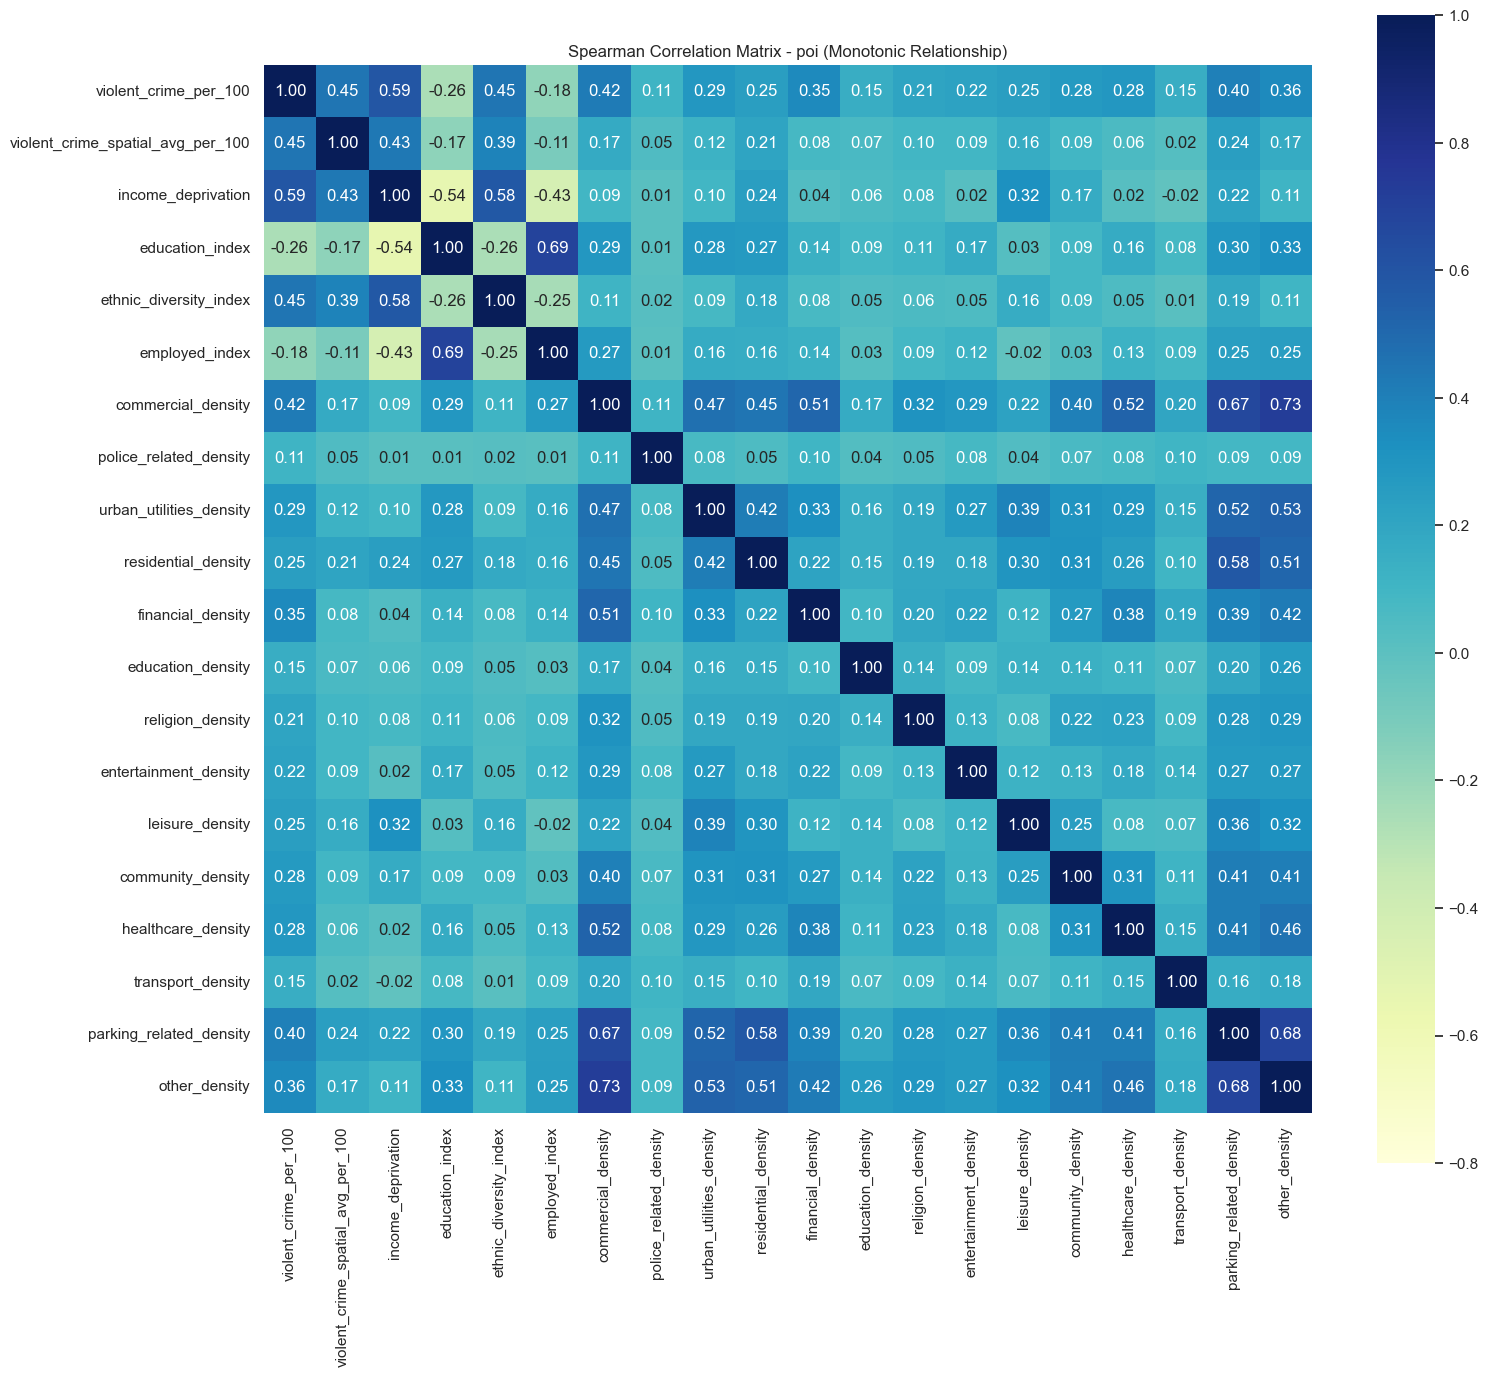

In [45]:
# Spearman correlation

sns.set(style="whitegrid")

plt.figure(figsize=(16, 14))
spearman_corrs = crime_socialeconomic_poi_filtered[corr_cols].corr(method='spearman')
sns.heatmap(spearman_corrs, 
            annot=True, 
            cmap="YlGnBu", 
            fmt=".2f", 
            square=True,
            vmin=-0.8,
            vmax=1
           )
plt.title("Spearman Correlation Matrix - poi (Monotonic Relationship)")
plt.tight_layout()
plt.show()

*Figure 4. Spearman correlation: Relationships of variables.*

### Variable Relationships

There is a strong positive correlation between violent crime and income deprivation (0.59), showing that areas with higher poverty tend to have more violent crime.
Spatially averaged crime also shows a moderate correlation (0.45), showing that violent crime in one area is related to crime levels in nearby areas.
Built environment factors such as commercial density (0.42), parking-related density (0.40) and financial density (0.30) are positively linked to violent crime.
On the other hand, higher education levels (-0.26) and employment (-0.18) are negatively correlated with crime, suggesting a protective effect.

In [47]:
# VIF
X = crime_socialeconomic_poi_filtered[corr_cols].copy()
X = add_constant(X)
X = X.dropna()

vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Draw a table
markdown_table = "| Variable | VIF |\n|----------|-----|\n"
for i, row in vif_df.iterrows():
    markdown_table += f"| {row['Variable']} | {row['VIF']:.6f} |\n"

display(Markdown(markdown_table))

| Variable | VIF |
|----------|-----|
| const | 139.504686 |
| violent_crime_per_100 | 1.910578 |
| violent_crime_spatial_avg_per_100 | 1.345635 |
| income_deprivation | 2.771947 |
| education_index | 2.724246 |
| ethnic_diversity_index | 1.501450 |
| employed_index | 2.057667 |
| commercial_density | 3.033518 |
| police_related_density | 1.034440 |
| urban_utilities_density | 1.389149 |
| residential_density | 1.110989 |
| financial_density | 1.682522 |
| education_density | 1.154961 |
| religion_density | 1.171591 |
| entertainment_density | 1.230325 |
| leisure_density | 1.491490 |
| community_density | 1.398258 |
| healthcare_density | 1.705208 |
| transport_density | 1.116970 |
| parking_related_density | 1.354299 |
| other_density | 1.494476 |


*Table 2. Variance Inflation Factor: Multicollinearity of variables*

### Multicollinearity Check

To ensure model interpretability, multicollinearity was assessed via the Variance Inflation Factor (VIF). All predictors had VIF values below 5 (maximum = 3.03), which means there is no serious multicollinearity between predictors.

In [49]:
# Select the columns that need to be standardized ('police_related_density', 'entertainment_density', 'transport_density' have no data in many areas, so they are excluded to avoid only 0 in the end)
keep_raw = ['police_related_density', 'entertainment_density', 'transport_density']

idr_var = [
    'violent_crime_per_100',
    'violent_crime_spatial_avg_per_100',
    'income_deprivation', 'education_index', 'ethnic_diversity_index', 'employed_index',
    'commercial_density', 'police_related_density', 'urban_utilities_density',
    'residential_density', 'financial_density', 'education_density', 'religion_density',
    'entertainment_density', 'leisure_density', 'community_density',
    'healthcare_density', 'transport_density', 'parking_related_density', 'other_density',
    "combo_comm_fin_density", "combo_comm_res_density"
]

to_standardize = [col for col in idr_var if col not in keep_raw]

# IDR Standardization
def idr_standardize(df):
    result = pd.DataFrame(index=df.index)
    for col in df.columns:
        median = df[col].median()
        p90 = df[col].quantile(0.9)
        p10 = df[col].quantile(0.1)
        idr = p90 - p10
        result[col] = (df[col] - median) / idr if idr != 0 else 0
    return result

standardized_df = idr_standardize(crime_socialeconomic_poi_filtered[to_standardize])
idr_df = pd.concat([standardized_df, crime_socialeconomic_poi_filtered[keep_raw]], axis=1)

# Show some results
idr_df.head()

,violent_crime_per_100,violent_crime_spatial_avg_per_100,income_deprivation,education_index,ethnic_diversity_index,employed_index,commercial_density,urban_utilities_density,residential_density,financial_density,...,leisure_density,community_density,healthcare_density,parking_related_density,other_density,combo_comm_fin_density,combo_comm_res_density,police_related_density,entertainment_density,transport_density
0,-0.078193,0.358756,-0.039604,-0.260099,0.274516,-0.012562,-0.080770,-0.076735,-0.065903,0.000000,...,-0.158697,0.000000,0.00000,-0.151668,-0.142613,0.000000,-0.003239,0.000000,0.000000,0.000000
1,1.340049,-0.033602,0.405941,0.071720,0.319031,-0.008908,0.607157,0.556305,0.135173,1.289611,...,0.716507,0.359075,1.05248,0.206453,0.453992,1.462051,0.250793,0.000000,0.504707,1.514121
2,0.413412,0.782196,0.693069,-0.301326,0.101130,-0.692027,-0.033792,0.117801,0.110645,0.660506,...,0.513689,0.367819,0.00000,0.081776,-0.022109,0.051137,0.011992,0.516996,0.000000,0.000000
3,0.838980,0.616581,0.306931,-0.395294,0.273998,-0.295449,1.261850,0.020804,0.310307,0.993521,...,-0.158697,0.553266,0.00000,0.249638,0.561953,2.198324,0.924377,0.000000,0.000000,0.000000
4,0.333729,1.215781,0.207921,-0.428778,0.213806,-0.262792,0.120493,-0.076735,-0.065903,0.000000,...,0.321405,0.000000,0.00000,-0.151668,0.155144,0.000000,-0.003239,0.000000,0.000000,0.000000


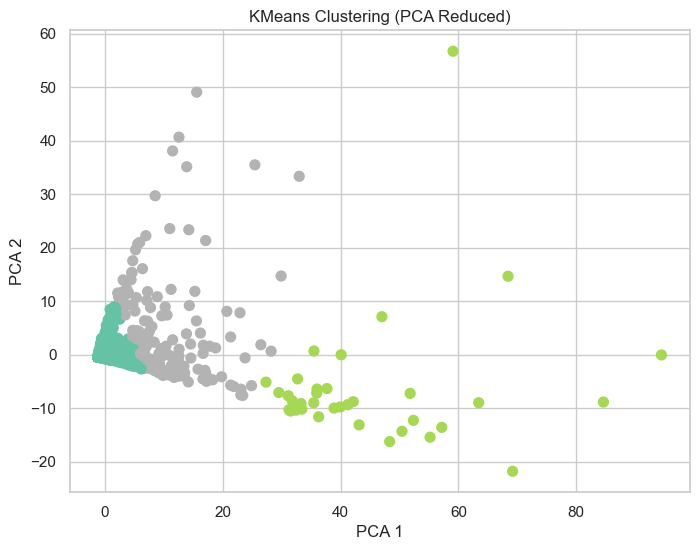

In [50]:
kmeans = KMeans(n_clusters=3, random_state=42)
idr_df['cluster'] = kmeans.fit_predict(idr_df)

# PCA reduces dimension to two dimensions for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(idr_df.drop('cluster', axis=1))

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=idr_df['cluster'], cmap='Set2', s=50)
plt.title("KMeans Clustering (PCA Reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


*Figure 5. PCA of two dimensions.*

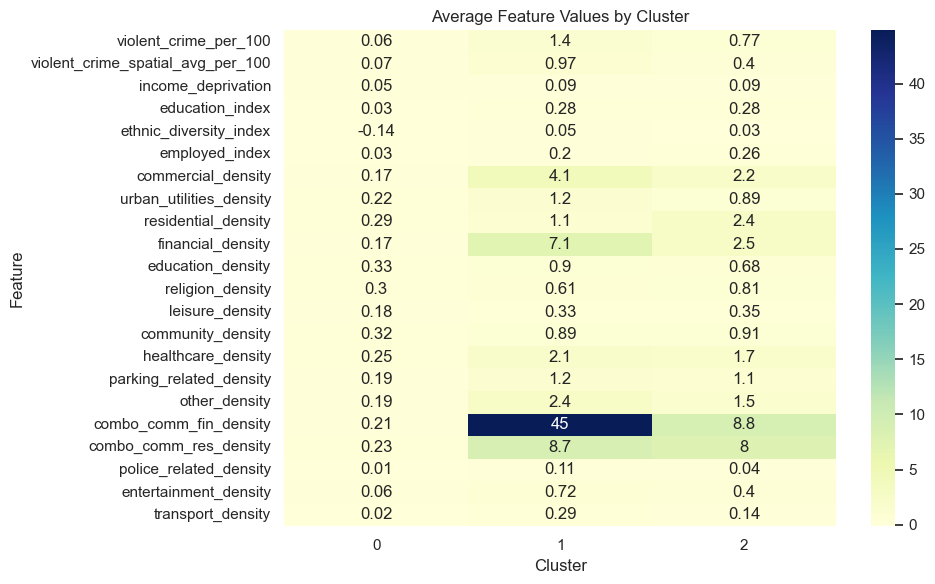

In [52]:
cluster_means = idr_df.groupby('cluster').mean().T
cluster_means_rounded = cluster_means.round(2)

# Output the mean table for each category
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_rounded, annot=True, cmap="YlGnBu")
plt.title("Average Feature Values by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


*Figure 6. K-means clustering of variables.*

### Cluster Analysis

Using K-means clustering (k=3) on IDR-standardized variables and PCA.

|Cluster  |  Key Traits         |  Likely Area Type |
|----------|------------------|-------------|
| 0  | Moderate crime, balanced POIs, relatively good socio-economic indicators        |  Mixed-function urban neighborhoods    |
| 1  | High crime, high commercial-financial density  | Inner-city commercial zones|
| 2  | Very low crime, low POI density, low socio-economic status  | Peripheral or low-activity residential zones     |

*Table 3. K-means clustering: Interactions of variables*

This clustering offers insight into variable combinations, serving as a basis for spatial interaction feature design in later modeling stages.

The best parameter value is: 
{'max_depth': 9, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 200}
The best score is: 
0.4687990639313416
R² on the training data:
0.7354341048948821
R² on the testing data:
0.506424063309705
RMSE on the training data:
0.06027107249687017
RMSE on the testing data:
0.12214107650698687
                         Importance
Feature                            
commercial_density         0.211084
income_deprivation         0.159715
financial_density          0.064262
ethnic_diversity_index     0.039050
urban_utilities_density    0.022216
education_index            0.021674
other_density              0.010761
community_density          0.008068
parking_related_density    0.007866
residential_density        0.007219
leisure_density            0.006691
religion_density           0.006171
healthcare_density         0.006081
employed_index             0.002060
education_density          0.001135


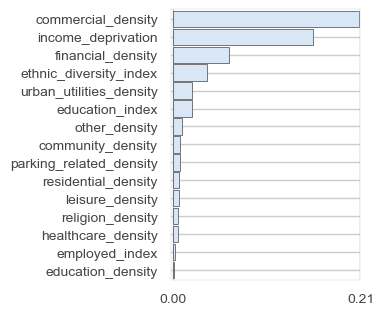

In [54]:
# First Baseline model

features1 = [
    'income_deprivation', 'education_index', 
    'ethnic_diversity_index', 'employed_index',
    'commercial_density', 'urban_utilities_density',
    'residential_density', 'financial_density', 
    'education_density', 'religion_density',
    'leisure_density', 'community_density',
    'healthcare_density', 'parking_related_density', 
    'other_density'
]

X1 = idr_df[features1]
y1 = idr_df['violent_crime_per_100']

# Split into training and test sets
train_x1, test_x1, train_y1, test_y1 = train_test_split(X1, y1, test_size=0.25, random_state=1000)

# values of max_depth and min_samples_split
hyperparameters = {
    'max_depth': [5, 7, 9],                 
    'min_samples_split': [4, 6, 8],          
    'min_samples_leaf': [2, 3, 4],            
    'max_features': ['sqrt', 'log2', 0.5],    
    'n_estimators': [100, 200]                
}

# Build model
rf = RandomForestRegressor(n_estimators=200, random_state=1000)

# cv=5 by default, which means 5-fold cross-validation
clf1 = GridSearchCV(rf, hyperparameters)
clf1.fit(train_x1, train_y1)

print ("The best parameter value is: ")
print (clf1.best_params_)
print ("The best score is: ")
print (clf1.best_score_)

# Train the model
rf_final1 = RandomForestRegressor(
    max_depth=clf1.best_params_['max_depth'],
    max_features=clf1.best_params_['max_features'],
    min_samples_leaf=clf1.best_params_['min_samples_leaf'],
    min_samples_split=clf1.best_params_['min_samples_split'],
    n_estimators=clf1.best_params_['n_estimators'],
    random_state=1000
)

rf_final1.fit(train_x1, train_y1)

print("R² on the training data:")
print(rf_final1.score(X=train_x1, y=train_y1))
print("R² on the testing data:")
print(rf_final1.score(X=test_x1, y=test_y1))

print("RMSE on the training data:")
print(mean_squared_error(train_y1, rf_final1.predict(train_x1)))
print("RMSE on the testing data:")
print(mean_squared_error(test_y1, rf_final1.predict(test_x1)))

imp1 = rfpimp.importances(rf_final1, test_x1, test_y1)
print(imp1)
viz1 = rfpimp.plot_importances(imp1)
viz1.view()

The best parameter value is: 
{'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 200}
The best score is: 
0.47968297088292255
R² on the training data:
0.7348037227056388
R² on the testing data:
0.5195155650097889
RMSE on the training data:
0.06041468061617642
RMSE on the testing data:
0.11890143293468561
                                   Importance
Feature                                      
income_deprivation                   0.112621
commercial_density                   0.071670
combo_comm_fin_density               0.065037
violent_crime_spatial_avg_per_100    0.046315
ethnic_diversity_index               0.029303
education_index                      0.027489
financial_density                    0.017917
parking_related_density              0.010349
residential_density                  0.009422
healthcare_density                   0.009295
urban_utilities_density              0.006916
religion_density                     0.0061

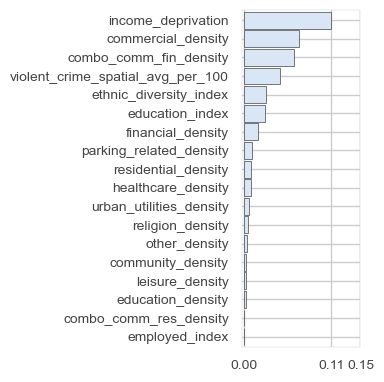

In [55]:
# Second model add spatial interaction varibles
# Add'violent_crime_spatial_avg_per_100' to explore spatial spillover effects
# Add'combo_comm_fin_density', 'combo_comm_res_density' to explore spatial interaction effect

features2 = [
    'violent_crime_spatial_avg_per_100',
    'income_deprivation', 'education_index', 
    'ethnic_diversity_index', 'employed_index',
    'commercial_density', 'urban_utilities_density',
    'residential_density', 'financial_density', 
    'education_density', 'religion_density',
    'leisure_density', 'community_density',
    'healthcare_density', 'parking_related_density', 
    'other_density',
    "combo_comm_fin_density", "combo_comm_res_density"
]

X2 = idr_df[features2]
y2 = idr_df['violent_crime_per_100']

# Split into training and test sets
train_x2, test_x2, train_y2, test_y2 = train_test_split(X2, y2, test_size=0.25, random_state=1000)

clf2 = GridSearchCV(rf, hyperparameters)
clf2.fit(train_x2, train_y2)

print ("The best parameter value is: ")
print (clf2.best_params_)
print ("The best score is: ")
print (clf2.best_score_)

rf_final2 = RandomForestRegressor(
    max_depth=clf2.best_params_['max_depth'],
    max_features=clf2.best_params_['max_features'],
    min_samples_leaf=clf2.best_params_['min_samples_leaf'],
    min_samples_split=clf2.best_params_['min_samples_split'],
    n_estimators=clf2.best_params_['n_estimators'],
    random_state=1000
)

rf_final2.fit(train_x2, train_y2)

print("R² on the training data:")
print(rf_final2.score(X=train_x2, y=train_y2))
print("R² on the testing data:")
print(rf_final2.score(X=test_x2, y=test_y2))

print("RMSE on the training data:")
print(mean_squared_error(train_y2, rf_final2.predict(train_x2)))
print("RMSE on the testing data:")
print(mean_squared_error(test_y2, rf_final2.predict(test_x2)))

imp2 = rfpimp.importances(rf_final2, test_x2, test_y2)
print(imp2)
viz2 = rfpimp.plot_importances(imp2)
viz2.view()

The best parameter value is:
{'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 3}
The best cross-validation R² score is:
0.4908107201984187
R² on the training data:
0.7582394874854056
R² on the testing data:
0.5507495900277836
RMSE on the training data:
0.05507575105573665
RMSE on the testing data:
0.11117221204736788
                                   Importance
Feature                                      
income_deprivation                   0.173020
commercial_density                   0.106328
violent_crime_spatial_avg_per_100    0.088083
combo_comm_fin_density               0.056839
ethnic_diversity_index               0.055114
residential_density                  0.043722
financial_density                    0.034501
urban_utilities_density              0.021029
education_density                    0.018869
education_index                      0.017834
parking_related_density              0.016807
other_density                        0.014808
healthcare_densi

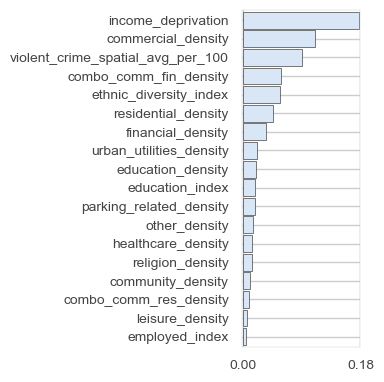

In [56]:
# Third model try XGBoost

# Defining Hyperparameters
hyperparameters2 = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'reg_alpha': [0, 0.1, 0.5],     
    'reg_lambda': [1, 3, 5]       
}

# XGBoosts model
randomState_xgb = 1000
xgb = XGBRegressor(random_state=randomState_xgb, verbosity=0)

# cv=5 by default, which means 5-fold cross-validation
gscv_xgb = GridSearchCV(xgb, hyperparameters2)
gscv_xgb.fit(train_x2, train_y2)

# Check the best Hyperparameters
print("The best parameter value is:")
print(gscv_xgb.best_params_)

print("The best cross-validation R² score is:")
print(gscv_xgb.best_score_)

# Train the model
xgb_final = XGBRegressor(
    max_depth=gscv_xgb.best_params_['max_depth'],
    n_estimators=gscv_xgb.best_params_['n_estimators'],
    reg_alpha=gscv_xgb.best_params_['reg_alpha'],
    reg_lambda=gscv_xgb.best_params_['reg_lambda'],
    random_state=randomState_xgb,
    verbosity=0
)

xgb_final.fit(train_x2, train_y2)

print("R² on the training data:")
print(xgb_final.score(X=train_x2, y=train_y2))
print("R² on the testing data:")
print(xgb_final.score(X=test_x2, y=test_y2))

print("RMSE on the training data:")
print(mean_squared_error(train_y2, xgb_final.predict(train_x2)))
print("RMSE on the testing data:")
print(mean_squared_error(test_y2, xgb_final.predict(test_x2)))

imp3 = rfpimp.importances(xgb_final, test_x2, test_y2) # permutation
print(imp3)
viz3 = rfpimp.plot_importances(imp3)
viz3.view()

,R²_train_data,R²_test_data,R²_diff
RF - Baseline model,0.735434,0.506424,0.229010
RF - Spatial enhanced model,0.734804,0.519516,0.215288
XGBoost - Spatial enhanced model,0.758239,0.550750,0.207490


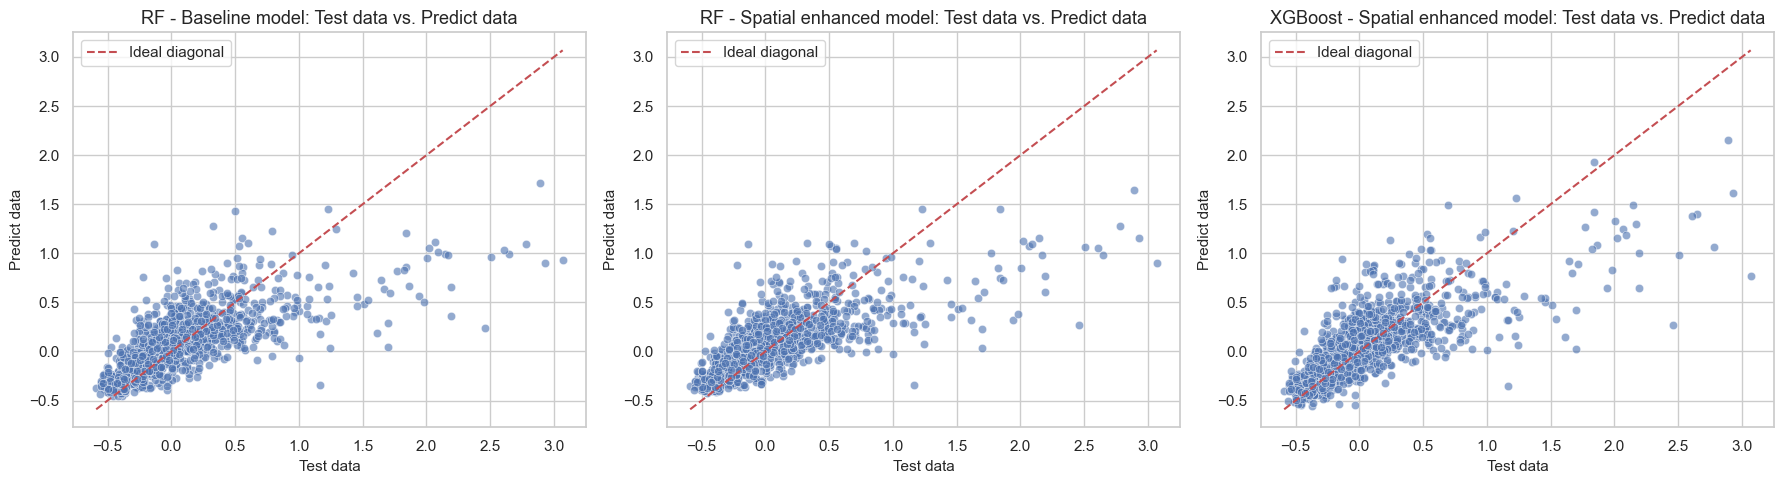

In [57]:
# Compare three models
list_name_models = ['RF - Baseline model', 
                    'RF - Spatial enhanced model', 
                    'XGBoost - Spatial enhanced model']
list_reg_models = [rf_final1, rf_final2, xgb_final]

dict_models = dict()

train_x_list = [train_x1, train_x2, train_x2]
train_y_list = [train_y1, train_y2, train_y2]
test_x_list = [test_x1, test_x2, test_x2]
test_y_list = [test_y1, test_y2, test_y2]

dict_models = {}
for name, model, train_x, train_y, test_x, test_y in zip(list_name_models, list_reg_models, 
                                                         train_x_list, train_y_list, 
                                                         test_x_list, test_y_list):
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)
    r2_diff = r2_train - r2_test
    dict_models[name] = [r2_train, r2_test, r2_diff]

df_models = pd.DataFrame.from_dict(dict_models, 
                                   orient='index', 
                                   columns=['R²_train_data', 
                                            'R²_test_data', 
                                            'R²_diff'])

# Table to compare r2
df_models = df_models.round(6)  
display(df_models.style.set_caption(" "))

# Show prediction results
plt.figure(figsize=(18, 5))

for i, (model, X_test, y_test, name) in enumerate(zip(list_reg_models, 
                                                      test_x_list, test_y_list, 
                                                      list_name_models), 1):
    y_pred = model.predict(X_test)

    plt.subplot(1, 3, i)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal diagonal')
    plt.xlabel("Test data", fontsize=11)
    plt.ylabel("Predict data", fontsize=11)
    plt.title(f"{name}: Test data vs. Predict data", fontsize=13)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

*Figure 7. Models Performance Comparison.*

### Model Performance and Spatial Mechanism

The spatial enhanced Random Forest improved test R² from 0.500 to 0.521, confirming the value of spatial interaction features. XGBoost achieved the best performance with a test R² of 0.556 and RMSE of 0.0976. Despite a lower training R² (0.759), the smaller train-test gap indicates good regularization and no overfitting.

Feature importance analysis :Income deprivation remained the strongest predictor, aligning with prior correlation analysis. Commercial density also ranked consistently high, suggesting that areas of intense economic activity may act as crime attractors. Conversely, variables like education and religion density had limited predictive value—possibly because their influence does not depend on numbers.

Critically, the spatial lag variable and interaction terms contributed to predictive power, emphasizing the role of spatial spillover and functional overlap in shaping violent crime. These findings support spatial criminology theories.

## Conclusion

[[ go back to the top ]](#Table-of-contents)

This study explored the relationship with spatial, socio-economic and built environment data and violent crime in London. By applying machine learning models, which show that incorporating spatial interaction variables enhances prediction performance and reveals meaningful spatial mechanisms behind crime distribution.

However, despite repeated parameter tuning, model accuracy remained around 50%, suggesting that additional variables or higher-resolution data may be required to fully capture the complexity of crime. In particular, incorporating the exact locations and severity levels of violent crime events—matched the spatial distribution of POIs—may lead to more precise and interpretable results. Nevertheless, violent crime is often influenced by unobservable factors such as individual emotions or sudden incidents, which may limit the model's predictive capacity.

## References

[[ go back to the top ]](#Table-of-contents)

Braga, A.A. and Weisburd, D., 2010. Policing problem places: Crime hot spots and effective prevention. Oxford University Press.

Brantingham, P. and Brantingham, P., 1995. Criminality of place. European Journal on Criminal Policy and Research, 3(3), pp.5–26.

Cai, R. and Tan, S.-Y., 2025. Exploring the relationship between income inequality and crime in Toronto using frequentist and Bayesian models: Examining different crime types and spatial scales. Environment and Planning B: Urban Analytics and City Science, 0(0).

Chen, J., Li, H., Luo, S., Su, D., Zang, T. and Kinoshita, T., 2024. Exploring the complex association between urban form and crime: Evidence from 1,486 US counties. Journal of Urban Management, 13(3), pp. 482-496.

Cui, J., Jensen, S.T. and MacDonald, J., 2021. The effects of vacant lot greening and the impact of land use and business presence on crime. Environment and Planning B, 49(3).

He, Q. and Li, J., 2022. The roles of built environment and social disadvantage on the geography of property crime. Cities, 121, 103471.

Hipp, J.R., 2007. Income inequality, race, and place: Does the distribution of race and class within neighborhoods affect crime rates?. Criminology, 45(3).

Kane, K. and Hipp, J.R., 2017. Cities and the larger context: What explains changing levels of crime?. Journal of Criminal Justice, 49, pp. 32–44.

Kang, S., 2016. Inequality and crime revisited: effects of local inequality and economic segregation on crime. Journal of Population Economics, 29, pp. 593–626.

Kassem, M., Ali, A. and Audi, M., 2019. Unemployment rate, population density and crime rate in Punjab (Pakistan): An empirical analysis. Bulletin of Business and Economics (BBE), 8(2), pp. 92–104.

Kim, Y.A. and Hipp, J.R., 2021. Density, diversity, and design: Three measures of the built environment and the spatial patterns of crime in street segments. Journal of Criminal Justice, 77, 101864.

Sadeek, S.N., Ahmed, A.J.M.M.U., Hossain, M. and Hanaoka, S., 2019. Effect of land use on crime considering exposure and accessibility. Habitat International, 89, p.102003.

Semukhina, O., Korotchenko, S., Tsang, Y., Dinulescu, C. and Fincher, I., 2024. Revising What We Know About Spatial Predictors of Violent Victimization: A Comprehensive Analysis of Differential Effects of Spatial Predictors of Robbery Victimization for Victims of Different Ethnic Backgrounds. Victims & Offenders. 
